# Notebook 3 — Avançado (GridSearchCV + MLP, foco em Recall)
Inclui gráficos e destaque do melhor resultado.

In [13]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

np.random.seed(42); tf.random.set_seed(42)
CSV_PATH = None
target_col = 'diagnosis'


In [31]:

from sklearn.datasets import load_breast_cancer

if CSV_PATH is None:
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name='target')
else:
    df = pd.read_csv(CSV_PATH)
    y = df[target_col].astype('category').cat.codes
    X = df.drop(columns=[target_col])


num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre = ColumnTransformer([('num', num_pipe, num_cols),
                         ('cat', cat_pipe, cat_cols)])

selector = SelectKBest(score_func=f_classif, k=min(20, (len(num_cols)+len(cat_cols))))
X_proc = pre.fit_transform(X)
X_sel = selector.fit_transform(X_proc, y)

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, stratify=y, random_state=42)


In [15]:

def build_mlp(layers=2, neurons=32, activation='relu', learning_rate=1e-3, dropout=0.0, input_dim=None):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(input_dim,)))
    for _ in range(layers-1):
        model.add(Dense(neurons, activation=activation))
        if dropout>0: model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(name='recall')])
    return model

mlp = KerasClassifier(
    model=build_mlp,
    model__input_dim=X_train.shape[1],  # prefixado também!
    verbose=0
)

param_grid = {
    'model__layers': [1, 2, 3],
    'model__neurons': [16, 32, 64],
    'model__activation': ['relu', 'tanh'],
    'model__learning_rate': [1e-3, 1e-2],
    'model__dropout': [0.0, 0.3],
    'batch_size': [16, 32],   # hiperparâmetro de treino (sem prefixo)
    'epochs': [40, 80]        # idem
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid.fit(X_train, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor recall (val. cruzada):", grid.best_score_)


c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Melhores parâmetros: {'batch_size': 16, 'epochs': 40, 'model__activation': 'tanh', 'model__dropout': 0.0, 'model__layers': 2, 'model__learning_rate': 0.001, 'model__neurons': 16}
Melhor recall (val. cruzada): 0.9964912280701753


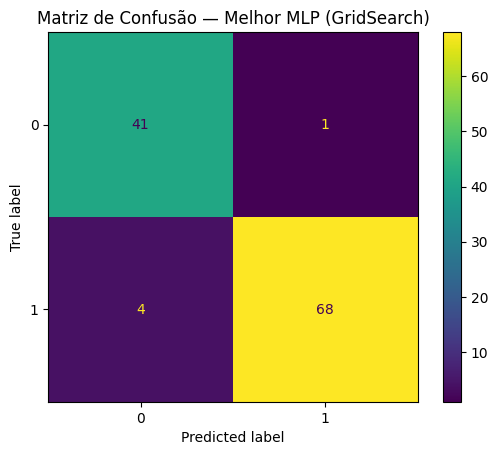

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        42
           1       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [16]:

best_est = grid.best_estimator_
y_pred = best_est.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de Confusão — Melhor MLP (GridSearch)")
plt.show()

print(classification_report(y_test, y_pred))


{'batch_size': 16, 'epochs': 40, 'model__activation': 'tanh', 'model__dropout': 0.0, 'model__layers': 2, 'model__learning_rate': 0.001, 'model__neurons': 16}
Epoch 1/40


c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6773 - recall: 0.5733 - val_loss: 0.5150 - val_recall: 0.9811
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4302 - recall: 0.9655 - val_loss: 0.3406 - val_recall: 0.9811
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2868 - recall: 0.9698 - val_loss: 0.2359 - val_recall: 0.9623
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2058 - recall: 0.9698 - val_loss: 0.1769 - val_recall: 0.9623
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1614 - recall: 0.9698 - val_loss: 0.1426 - val_recall: 0.9623
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1355 - recall: 0.9741 - val_loss: 0.1209 - val_recall: 0.9623
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1189 - recall: 0.9784 - val_loss: 0.1056 - val_recall: 0.9623
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1073 - recall: 0.9871 - val_loss: 0.0941 - val_recall: 0.9623
Epoch 9/40
23/23 ━━━━━━━━━━━━━━━━━

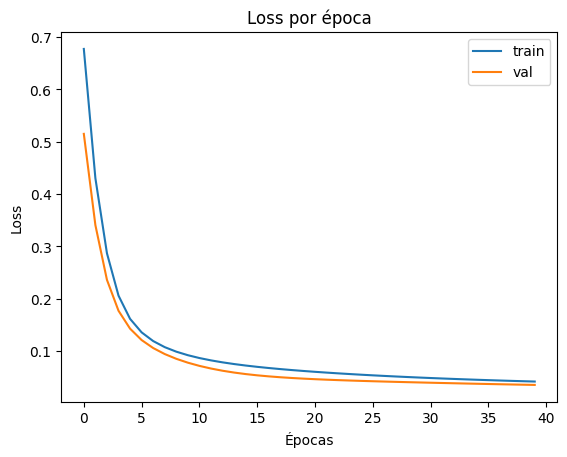

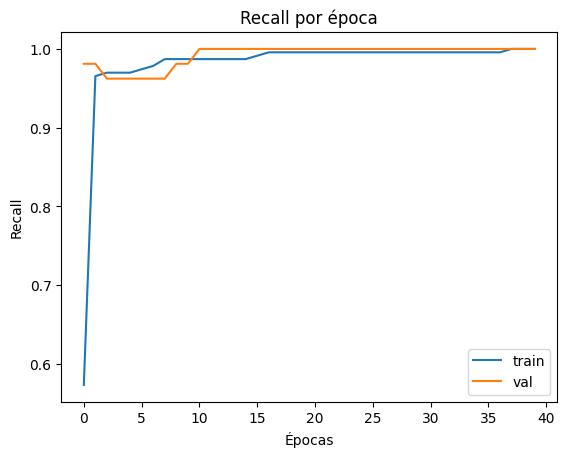

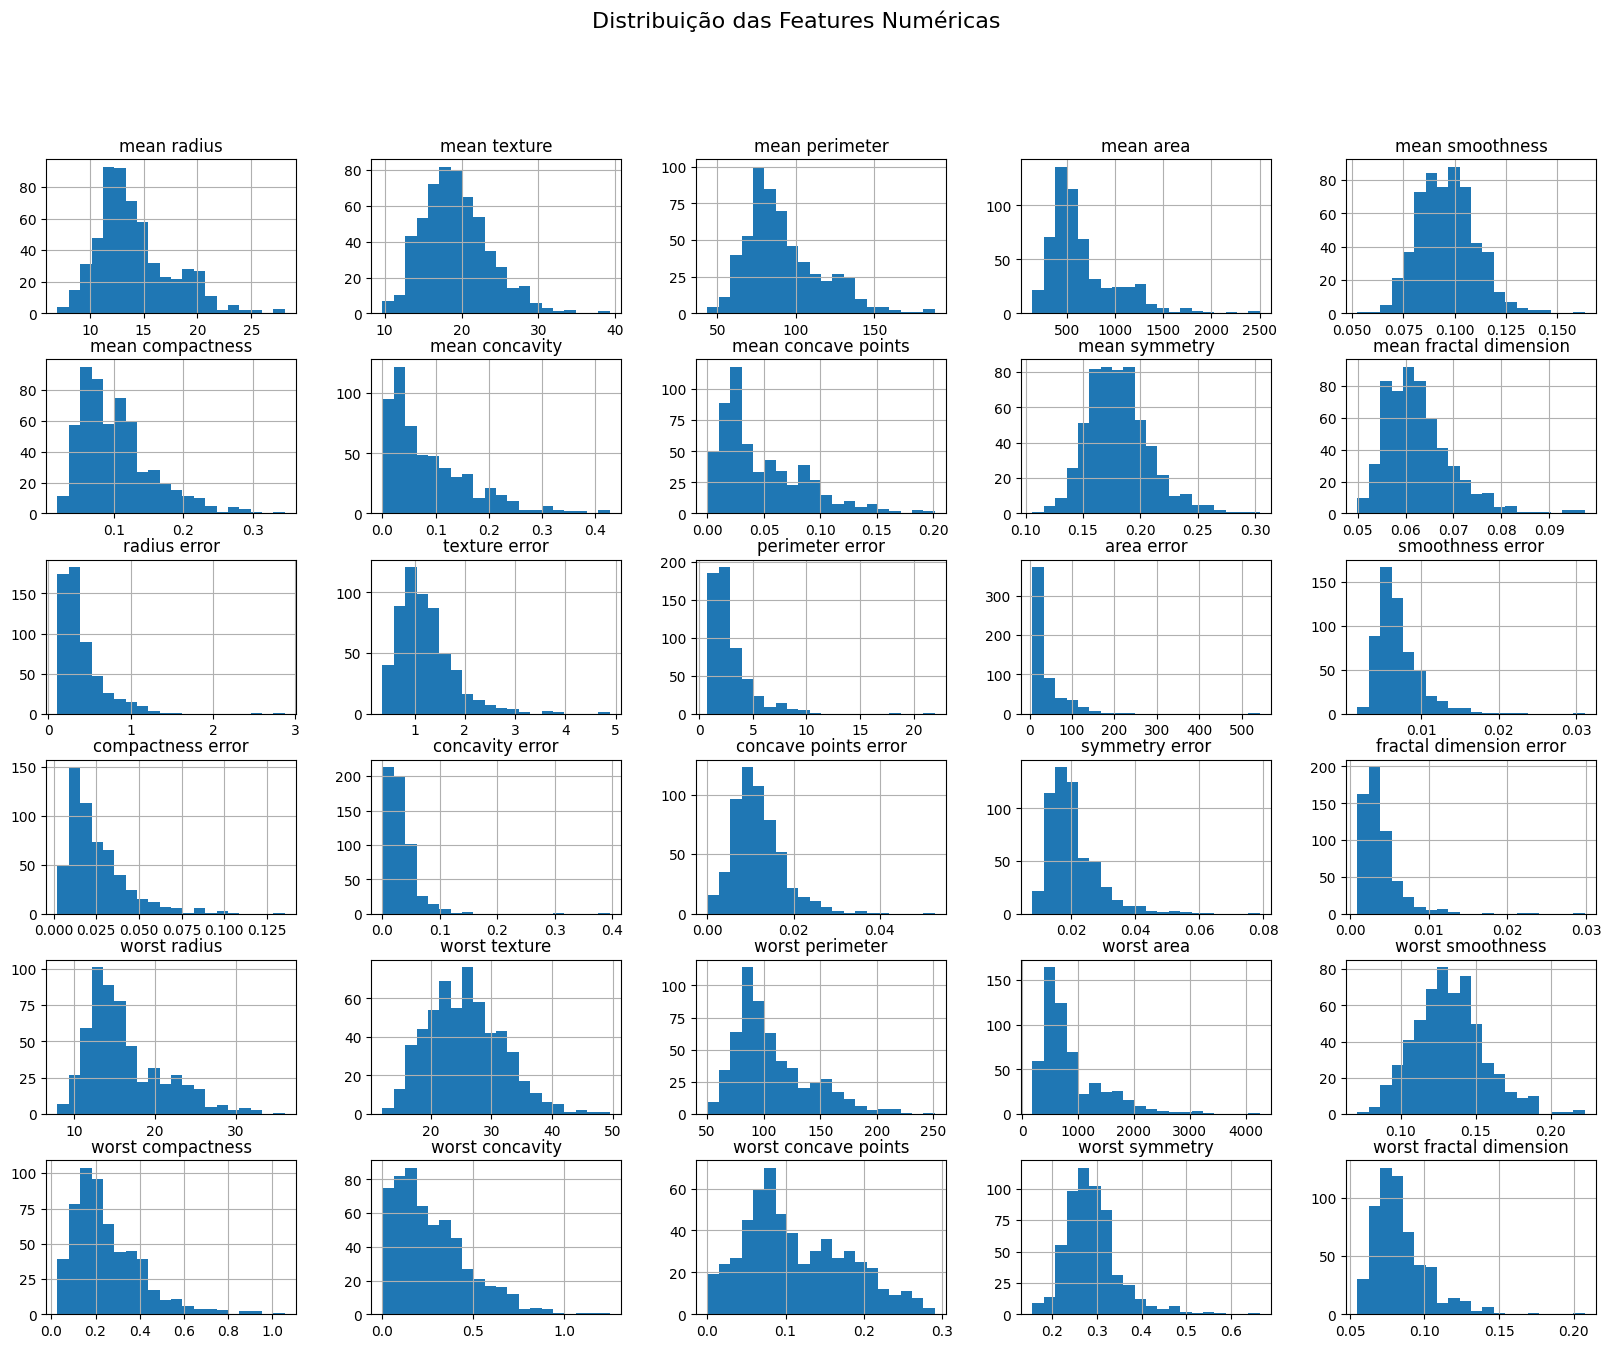

In [32]:
# Ver quais chaves estão no best_params_
print(grid.best_params_)

# Pegue os parâmetros corretos do modelo
best_params = {k.replace('model__',''): v for k,v in grid.best_params_.items()}

# Criar o modelo novamente com os melhores parâmetros
best_model = build_mlp(
    layers=best_params.get('layers', 2),
    neurons=best_params.get('neurons', 32),
    activation=best_params.get('activation', 'relu'),
    learning_rate=best_params.get('learning_rate', 1e-3),
    dropout=best_params.get('dropout', 0.0),
    input_dim=X_train.shape[1]
)

# Callback para salvar histórico
from tensorflow.keras.callbacks import History
history = History()

# Fit manual para capturar histórico
best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=best_params.get('epochs', 40),
    batch_size=best_params.get('batch_size', 32),
    callbacks=[history],
    verbose=1
)

# Plot Loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel("Épocas"); plt.ylabel("Loss"); plt.title("Loss por época"); plt.legend(); plt.show()

# Plot Recall
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='val')
plt.xlabel("Épocas"); plt.ylabel("Recall"); plt.title("Recall por época"); plt.legend(); plt.show()
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols].hist(figsize=(20,15), bins=20)
plt.suptitle("Distribuição das Features Numéricas", fontsize=16)
plt.show()

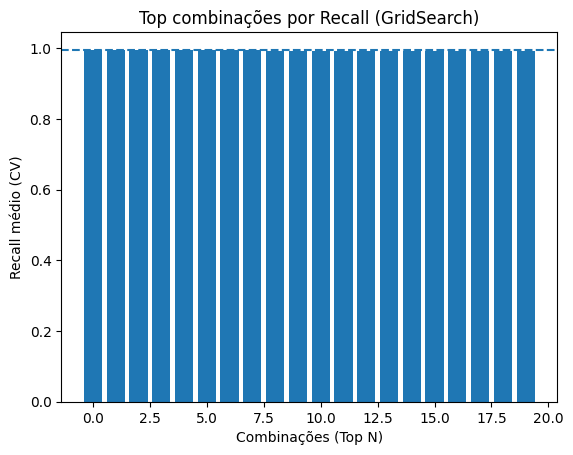

,mean_test_score,std_test_score,param_batch_size,param_epochs,param_model__activation,param_model__dropout,param_model__layers,param_model__learning_rate,param_model__neurons
0,0.996491,0.007018,32,40,relu,0.0,1,0.010,32
1,0.996491,0.007018,32,80,relu,0.0,1,0.010,16
2,0.996491,0.007018,16,40,tanh,0.0,2,0.001,16
3,0.996491,0.007018,32,40,tanh,0.3,3,0.001,32
4,0.996491,0.007018,32,40,tanh,0.0,1,0.010,16
5,0.996491,0.007018,32,40,tanh,0.3,1,0.010,32
6,0.996491,0.007018,32,80,tanh,0.3,3,0.010,16
7,0.996491,0.007018,32,40,relu,0.0,3,0.001,32
8,0.992982,0.008595,16,40,tanh,0.3,2,0.001,16
9,0.992982,0.008595,32,80,relu,0.0,1,0.001,64


In [18]:

# Comparação das combinações do Grid — gráfico de barras + destaque do melhor
import pandas as pd, numpy as np
cv_results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False).reset_index(drop=True)

TOP_N = 20
means = cv_results['mean_test_score'].head(TOP_N).to_numpy()
indices = np.arange(len(means))

plt.bar(indices, means)
plt.xlabel("Combinações (Top N)"); plt.ylabel("Recall médio (CV)")
plt.title("Top combinações por Recall (GridSearch)")
plt.axhline(means[0], linestyle='--')  # destaca a melhor
plt.show()

# Mostrar tabela com os parâmetros das Top-N
param_cols = [c for c in cv_results.columns if c.startswith('param_')]
display_cols = ['mean_test_score', 'std_test_score'] + param_cols
cv_results[display_cols].head(TOP_N)
